In [153]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score, max_error, mean_absolute_error, mean_absolute_percentage_error

from keras import models, layers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})

## Carregar os dados

In [154]:
df = pd.read_pickle("..//datasets/processed/laptop_price.pkl")
df.head()

,company,typename,inches,screen_resolution,x_screen,y_screen,cpu_manufacturer,cpu_ghz,gpu_manufacturer,ram_gb,memory_principal_gb,memory_principal_type,memory_secondary_gb,memory_secondary_type,opsys,weight_kg,price_euros
0,Apple,Ultrabook,14-,2560x1600,2560,1600,Intel,2.3,Intel,8,128,ssd,0,empty,macOS,1.37,1339.69
1,Apple,Ultrabook,14-,1440x900,1440,900,Intel,1.8,Intel,8,128,flash storage,0,empty,macOS,1.34,898.94
2,HP,Notebook,14~16,1920x1080,1920,1080,Intel,2.5,Intel,8,256,ssd,0,empty,Outros,1.86,575.00
3,Apple,Ultrabook,14~16,2880x1800,2880,1800,Intel,2.7,AMD,16,512,ssd,0,empty,macOS,1.83,2537.45
4,Apple,Ultrabook,14-,2560x1600,2560,1600,Intel,3.1,Intel,8,256,ssd,0,empty,macOS,1.37,1803.60


In [155]:
features = df.drop(columns='price_euros')
for item in ['company', 'typename', 'inches', 'screen_resolution', 'cpu_manufacturer', 'gpu_manufacturer', 'memory_principal_type', 'memory_secondary_type', 'opsys']:
    features[item] = LabelEncoder().fit_transform(features[item])
target = df.price_euros

train_x, test_x, train_y, test_y = train_test_split(features, target, test_size=0.3)

In [156]:
def create_model(model):
    return Pipeline(
    steps=[
        ("preprocessor", SimpleImputer(strategy="median")), 
        ("scaler", StandardScaler()), 
        ("model", model)
    ]
)

## Models

In [157]:
def create_scores(model_list, train_x, train_y, test_x, test_y):
    scores = {
        "Algorithm": [],
        "R2": [],
        "Max Error": [],
        "Mean Absolute Error": [],
        "Mean Absolute Percentage Error": []
    }
    for name, model_ in model_list.items():
        model = create_model(model_)
        model.fit(train_x, train_y)
        pred_y = model.predict(test_x)
        
        scores['Algorithm'].append(name.rsplit(' ', 1)[0])
        scores['R2'].append(round(r2_score(test_y,pred_y), 2))
        scores['Max Error'].append(round(max_error(test_y,pred_y), 2))
        scores['Mean Absolute Error'].append(round(mean_absolute_error(test_y,pred_y), 2))
        scores['Mean Absolute Percentage Error'].append(round(mean_absolute_percentage_error(test_y, pred_y) * 100, 2))

    return pd.DataFrame(scores)

def plot_scores(results, title, ax, rot=45):
    sns.barplot(data=results, x='Algorithm', y=title, palette="flare", ax=ax)
    for value in ax.containers:
        ax.bar_label(value)
    ax.tick_params(axis='x', labelrotation=rot, size=12)
    ax.tick_params(axis='y', size=12)
    ax.set(ylabel=None, xlabel=None)
    ax.set_title(f"{title.capitalize()}", fontsize='large', fontweight='bold', 
            style='italic', family='monospace')
    ax.grid(visible=True, color='black', linewidth=.25)

With Pipeline

In [158]:
model_list = {
    'Random Forest Regressor': create_model(RandomForestRegressor()),
    'KNeighbors Regressor': create_model(KNeighborsRegressor()),
    'Decision Tree Regressor': create_model(DecisionTreeRegressor()),
    'Linear Regression': create_model(LinearRegression())
}
scores = create_scores(model_list, train_x, train_y, test_x, test_y)
scores

,Algorithm,R2,Max Error,Mean Absolute Error,Mean Absolute Percentage Error
0,Random Forest,0.85,1813.95,173.45,16.47
1,KNeighbors,0.76,1684.62,229.66,23.22
2,Decision Tree,0.72,2619.99,220.95,20.94
3,Linear,0.65,2528.71,280.52,31.05


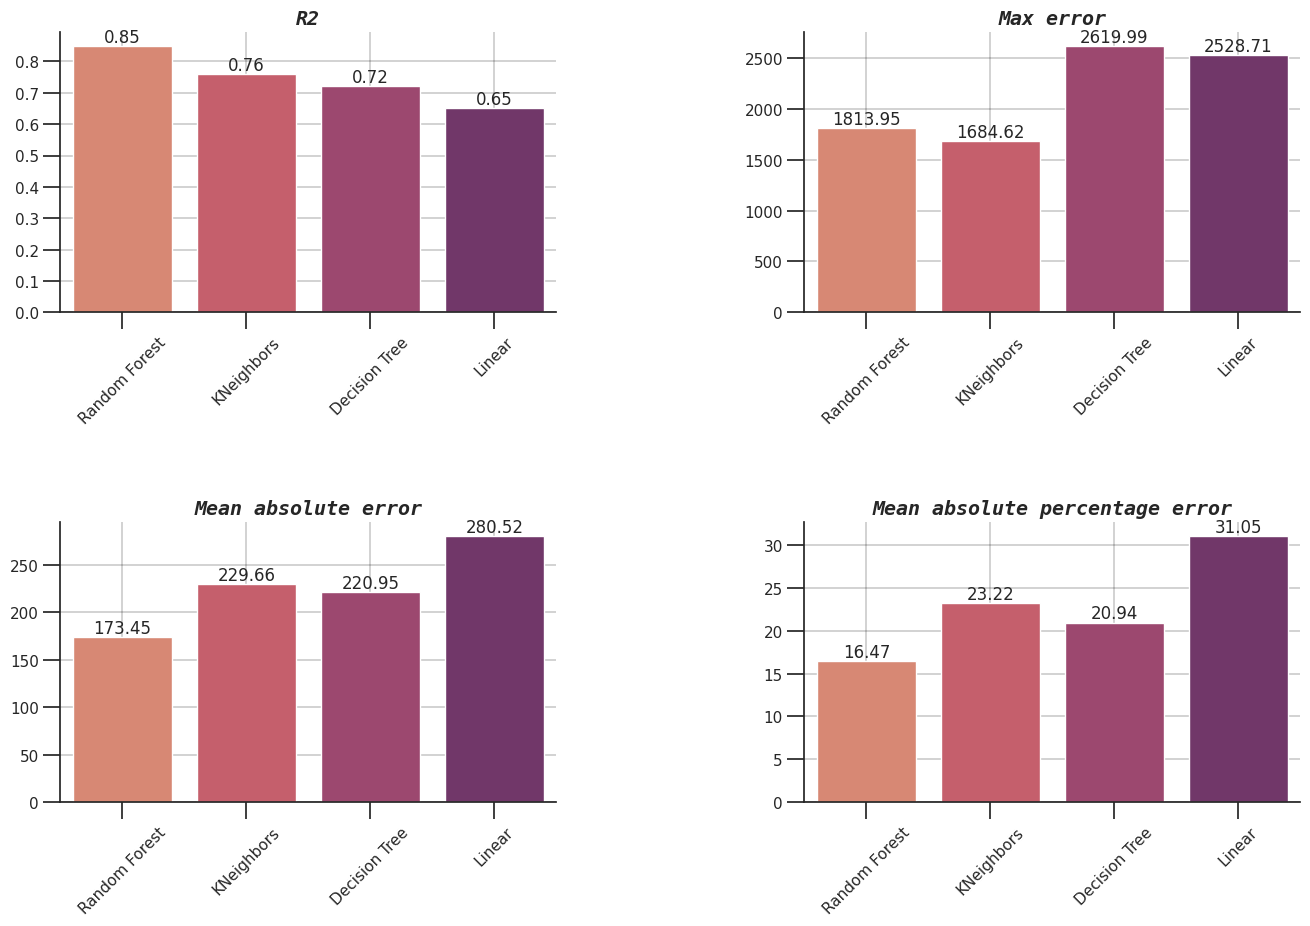

In [159]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
plot_scores(scores, 'R2', ax1, rot=45)
plot_scores(scores, 'Max Error', ax2, rot=45)
plot_scores(scores, 'Mean Absolute Error', ax3, rot=45)
plot_scores(scores, 'Mean Absolute Percentage Error', ax4, rot=45)
plt.subplots_adjust(wspace=.5, hspace=.75)
plt.show()

Without Pipeline

In [160]:
model_list = {
    'Random Forest Regressor': RandomForestRegressor(),
    'KNeighbors Regressor': KNeighborsRegressor(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Linear Regression ': LinearRegression()
}
scores = create_scores(model_list, train_x, train_y, test_x, test_y)
scores

,Algorithm,R2,Max Error,Mean Absolute Error,Mean Absolute Percentage Error
0,Random Forest,0.84,1789.17,177.18,16.94
1,KNeighbors,0.76,1684.62,229.66,23.22
2,Decision Tree,0.70,2619.99,222.48,20.53
3,Linear Regression,0.65,2528.71,280.52,31.05


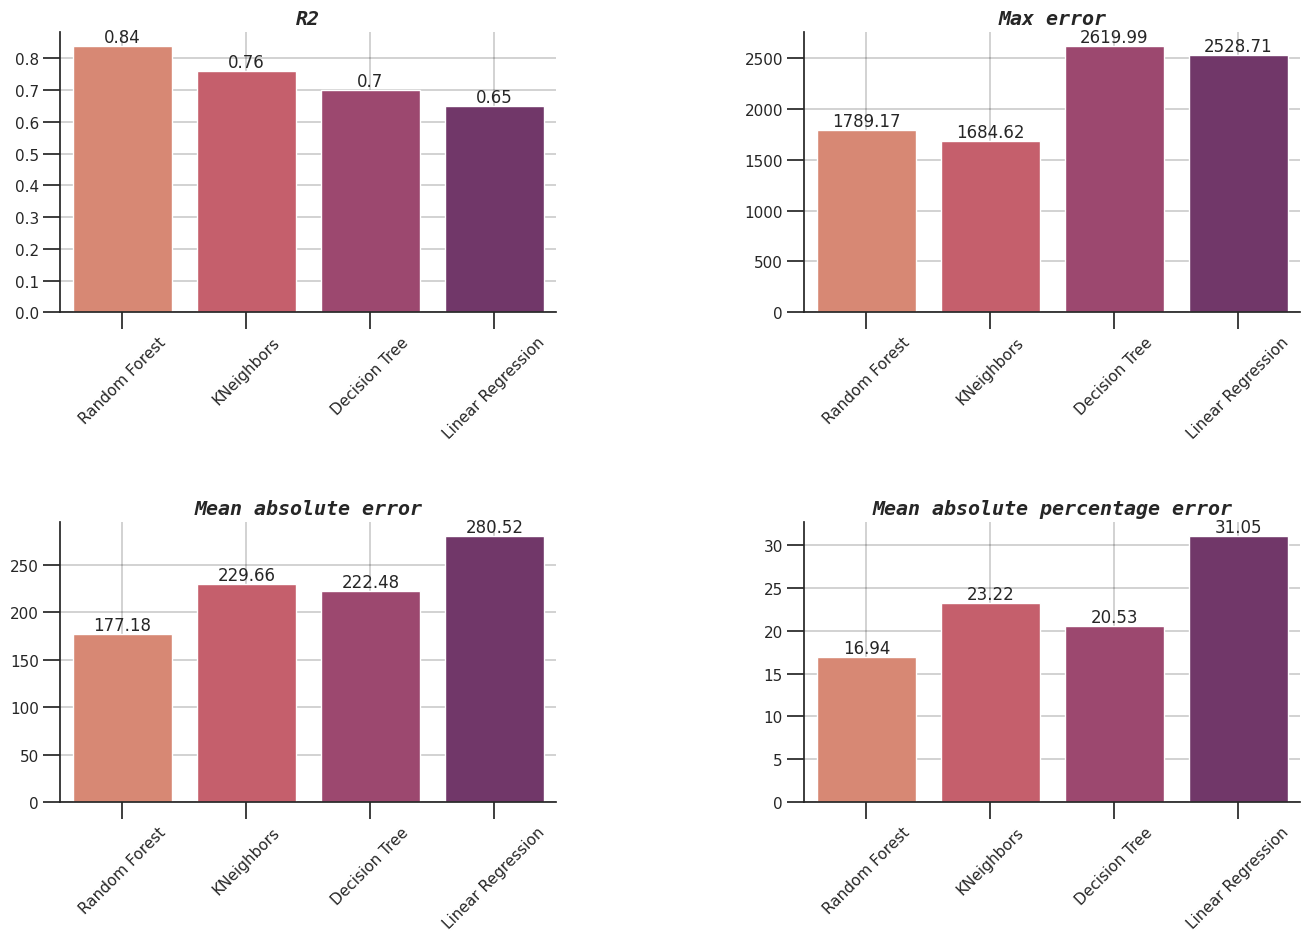

In [161]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
plot_scores(scores, 'R2', ax1, rot=45)
plot_scores(scores, 'Max Error', ax2, rot=45)
plot_scores(scores, 'Mean Absolute Error', ax3, rot=45)
plot_scores(scores, 'Mean Absolute Percentage Error', ax4, rot=45)
plt.subplots_adjust(wspace=.5, hspace=.75)
plt.show()

## Best Params

With Pipeline

In [162]:
model_list = {
    'Random Forest Regressor': create_model(RandomForestRegressor(bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100)),
    'KNeighbors Regressor': create_model(KNeighborsRegressor(n_neighbors=3)),
    'Decision Tree Regressor': create_model(DecisionTreeRegressor(max_depth= 12, max_features= 'sqrt', max_leaf_nodes= 90, min_samples_leaf= 1, splitter= 'best')),
    'Linear Regression': create_model(LinearRegression(copy_X=True, n_jobs=1, positive=False))
}

scores = create_scores(model_list, train_x, train_y, test_x, test_y)
scores

,Algorithm,R2,Max Error,Mean Absolute Error,Mean Absolute Percentage Error
0,Random Forest,0.80,2017.27,201.25,21.20
1,KNeighbors,0.77,1438.10,222.55,22.49
2,Decision Tree,0.69,1962.96,241.74,24.72
3,Linear,0.65,2528.71,280.52,31.05


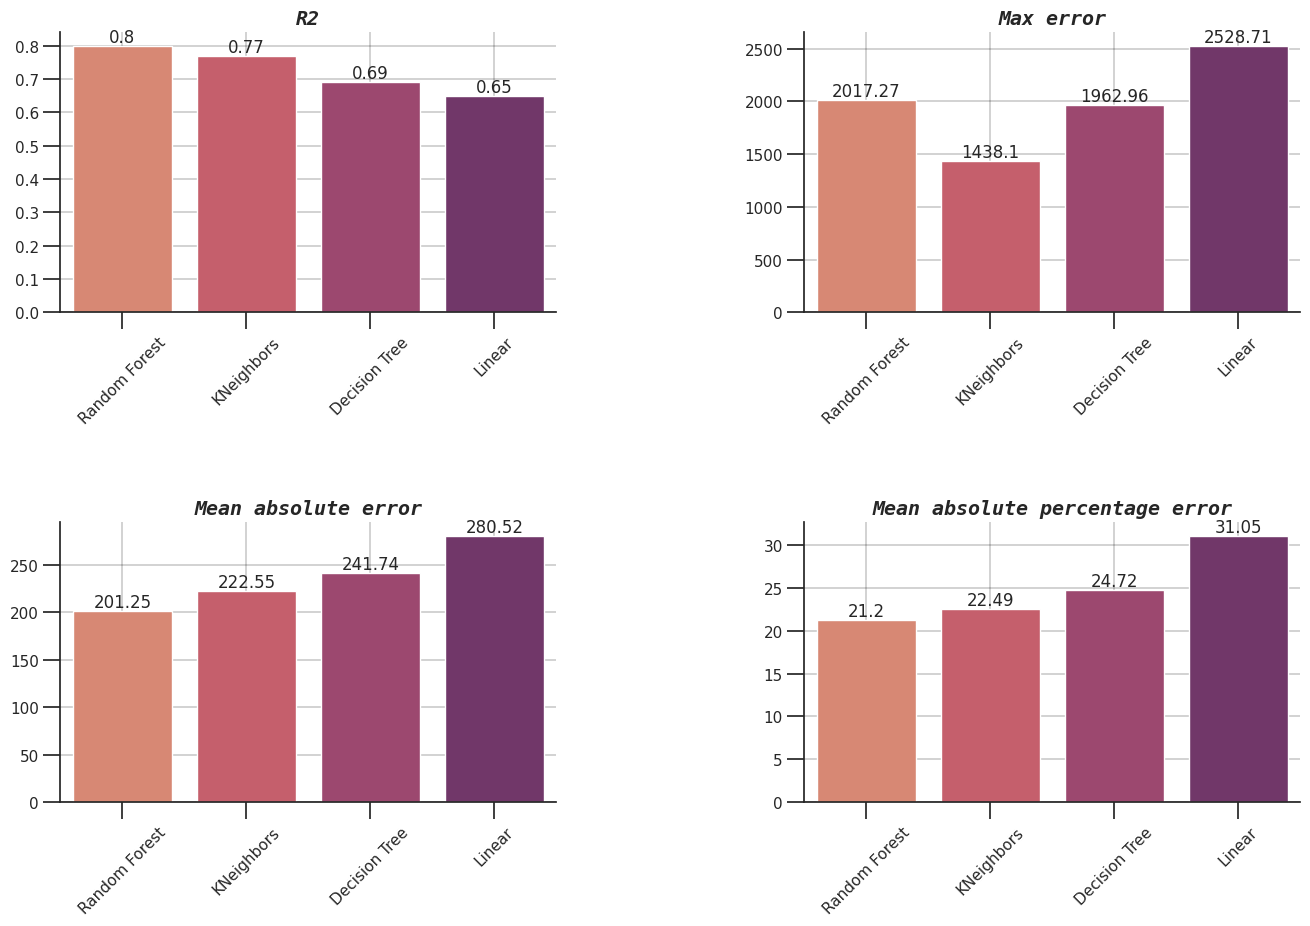

In [163]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
plot_scores(scores, 'R2', ax1, rot=45)
plot_scores(scores, 'Max Error', ax2, rot=45)
plot_scores(scores, 'Mean Absolute Error', ax3, rot=45)
plot_scores(scores, 'Mean Absolute Percentage Error', ax4, rot=45)
plt.subplots_adjust(wspace=.5, hspace=.75)
plt.show()

Without Pipeline

In [164]:
model_list = {
    'Random Forest Regressor': RandomForestRegressor(bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100),
    'KNeighbors Regressor': KNeighborsRegressor(n_neighbors=3),
    'Decision Tree Regressor': DecisionTreeRegressor(max_depth= 12, max_features= 'sqrt', max_leaf_nodes= 90, min_samples_leaf= 1, splitter= 'best'),
    'Linear Regression': LinearRegression(copy_X=True, n_jobs=1, positive=False)
}
scores = create_scores(model_list, train_x, train_y, test_x, test_y)
scores

,Algorithm,R2,Max Error,Mean Absolute Error,Mean Absolute Percentage Error
0,Random Forest,0.81,2030.04,198.88,21.30
1,KNeighbors,0.77,1438.10,222.90,22.52
2,Decision Tree,0.67,2260.00,249.83,26.21
3,Linear,0.65,2528.71,280.52,31.05


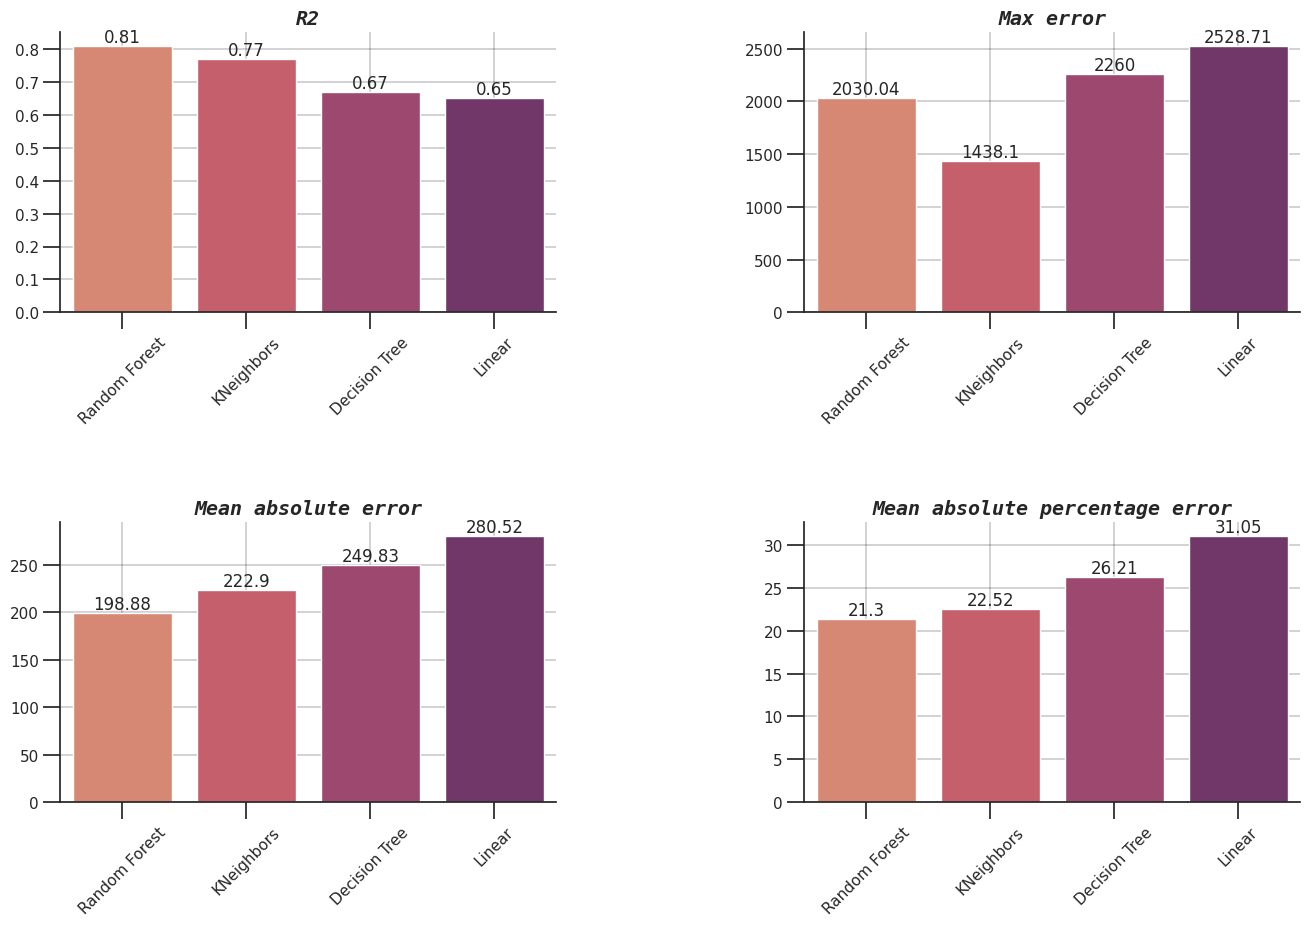

In [165]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
plot_scores(scores, 'R2', ax1, rot=45)
plot_scores(scores, 'Max Error', ax2, rot=45)
plot_scores(scores, 'Mean Absolute Error', ax3, rot=45)
plot_scores(scores, 'Mean Absolute Percentage Error', ax4, rot=45)
plt.subplots_adjust(wspace=.5, hspace=.75)
plt.show()

### Random Forest Regression

In [166]:
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [80, 90, 100, 110],
#     'max_features': [2, 3],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300, 1000]
# }

### KNeighbors Regression

In [167]:
# param_grid = dict(n_neighbors=np.arange(1, 100))

### Decision Tree Regression

In [168]:
# param_grid={"splitter":["best","random"],
#            "max_depth" : [1,3,5,7,9,11,12],
#            "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
#            "max_features":["log2","sqrt"],
#            "max_leaf_nodes":[10,20,30,40,50,60,70,80,90]
# }

### Linear Regression

In [169]:
# param_grid = {
#     'copy_X': [True, False],
#     'fit_intercept': [True, False],
#     'n_jobs': np.arange(1, 100),
#     'positive': [True, False]
# }

## Experiments

In [170]:
def experiment(model, features, target, n_splits=5):
    kf = KFold(n_splits=n_splits)

    scores = {
        "train_count": [],
        "valid_count": [],
        "train_true_percent": [],
        "valid_true_percent": [],
        "train_scores": [],
        "valid_scores": []
    }

    for train_index, valid_index in kf.split(features):
        train_x, train_y = features.iloc[train_index], target.iloc[train_index]
        valid_x, valid_y = features.iloc[valid_index], target.iloc[valid_index]
        
        model.fit(train_x, train_y)

        scores['train_count'].append(train_x.shape[0])
        scores['valid_count'].append(valid_x.shape[0])
        scores['train_true_percent'].append(train_y.sum() / train_y.shape[0])
        scores['valid_true_percent'].append(valid_y.sum() / valid_y.shape[0])
        scores['train_scores'].append( r2_score(train_y, model.predict(train_x)) )
        scores['valid_scores'].append( r2_score(valid_y, model.predict(valid_x)) )
    
    return pd.DataFrame(scores)

def validation_curve(results, title, ax):
    x = np.arange(results.shape[0])
    
    if results.train_scores.max() < results.valid_scores.max():
        max = results.valid_scores.max()
    else:
        max = results.train_scores.max()
    if results.train_scores.min() > results.valid_scores.min():
        min = results.valid_scores.min()
    else:
        min = results.train_scores.min()
        
    min = round(min, 1)
    max = round(max, 1)
    
    sns.lineplot(data=results, x=x, y='train_scores', marker= 'o', markersize=10, ax=ax)
    sns.lineplot(data=results, x=x, y='valid_scores', marker= 'o', markersize=10, ax=ax)
    
    ax.set(ylabel=None)
    ax.grid(visible=True, color='black', linewidth=.5)
    ax.set_title(title)
    ax.set_ylim(min-0.1, max+0.1)
    ax.legend(['Training Scores', 'Validation Scores'])

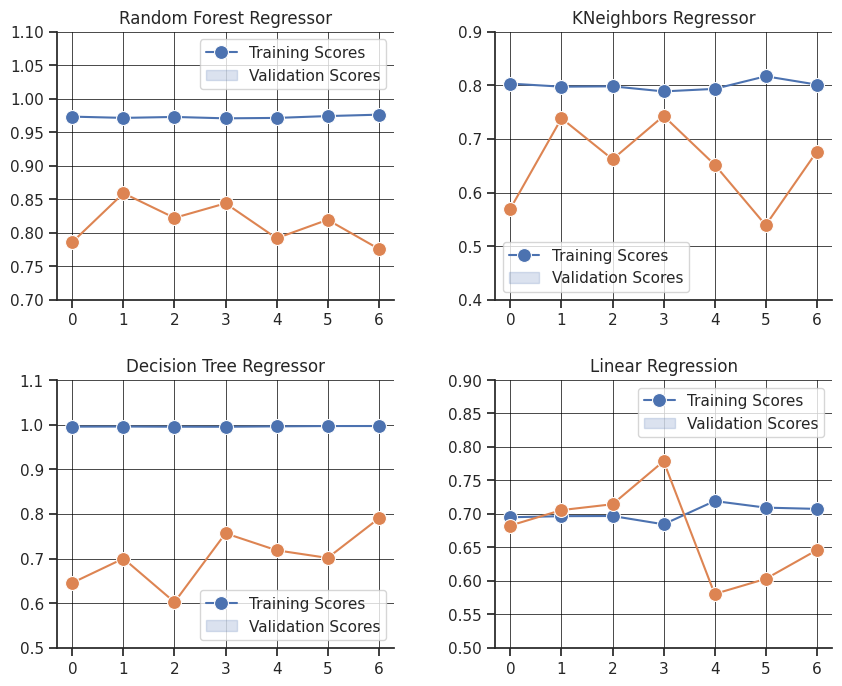

In [171]:
model_list = {
    'Random Forest Regressor': RandomForestRegressor(),
    'KNeighbors Regressor': KNeighborsRegressor(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Linear Regression': LinearRegression()
}

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

model_results = list()
for ax, (model_name, model) in zip([ax1, ax2, ax3, ax4], model_list.items()):
    results = experiment(model, features, target, n_splits=7)
    results['model'] = model_name
    model_results.append(results)

    validation_curve(results, model_name, ax)
model_results = pd.concat(model_results, axis=0)

plt.subplots_adjust(wspace=.3, hspace=.3)
plt.show()

In [172]:
model_results.groupby('model', as_index=False).agg({
    'train_scores': ['mean', 'std', 'min', 'max'],
    'valid_scores': ['mean', 'std', 'min', 'max']
}).round(3)

model train_scores                      valid_scores  \
                                   mean    std    min    max         mean   
0  Decision Tree Regressor        0.996  0.001  0.995  0.997        0.702   
1     KNeighbors Regressor        0.800  0.009  0.789  0.817        0.654   
2        Linear Regression        0.701  0.011  0.684  0.719        0.673   
3  Random Forest Regressor        0.973  0.002  0.971  0.976        0.814   

                        
     std    min    max  
0  0.063  0.602  0.790  
1  0.077  0.539  0.743  
2  0.069  0.580  0.779  
3  0.031  0.776  0.859

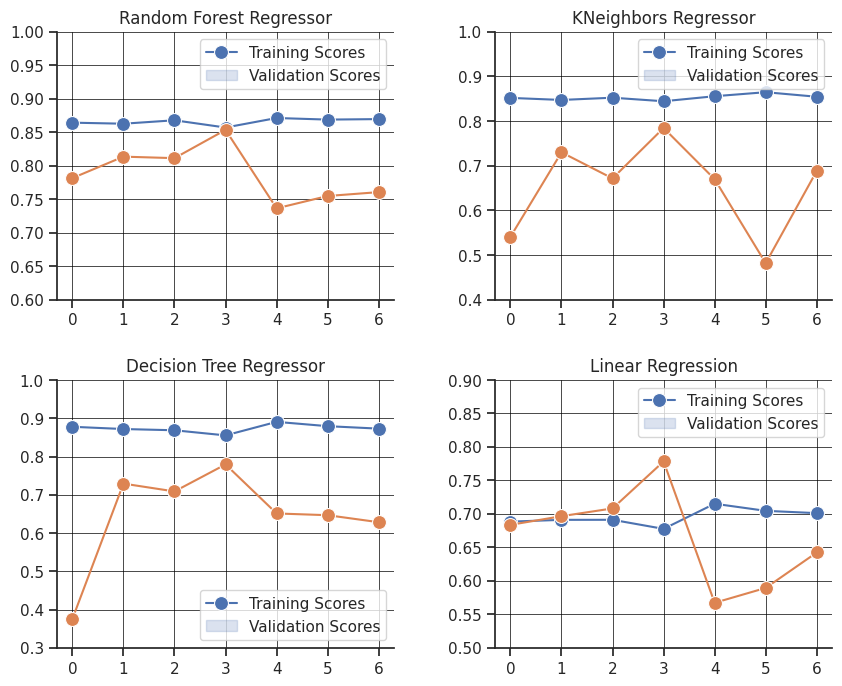

In [173]:
model_list = {
    'Random Forest Regressor': RandomForestRegressor(bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100),
    'KNeighbors Regressor': KNeighborsRegressor(n_neighbors=3),
    'Decision Tree Regressor': DecisionTreeRegressor(max_depth= 12, max_features= 'sqrt', max_leaf_nodes= 90, min_samples_leaf= 1, splitter= 'best'),
    'Linear Regression': LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, positive=False)
}

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

model_results = list()
for ax, (model_name, model) in zip([ax1, ax2, ax3, ax4], model_list.items()):
    results = experiment(model, features, target, n_splits=7)
    results['model'] = model_name
    model_results.append(results)

    validation_curve(results, model_name, ax)
model_results = pd.concat(model_results, axis=0)

plt.subplots_adjust(wspace=.3, hspace=.3)
plt.show()

In [174]:
model_results.groupby('model', as_index=False).agg({
    'train_scores': ['mean', 'std', 'min', 'max'],
    'valid_scores': ['mean', 'std', 'min', 'max']
}).round(3)

model train_scores                      valid_scores  \
                                   mean    std    min    max         mean   
0  Decision Tree Regressor        0.874  0.011  0.855  0.891        0.646   
1     KNeighbors Regressor        0.853  0.006  0.844  0.865        0.652   
2        Linear Regression        0.696  0.012  0.678  0.715        0.667   
3  Random Forest Regressor        0.866  0.005  0.857  0.871        0.787   

                        
     std    min    max  
0  0.130  0.375  0.779  
1  0.106  0.482  0.785  
2  0.073  0.567  0.778  
3  0.041  0.736  0.854

# Neural Network

In [175]:
def create_network(units_1, units_2, input_shape, activation, optimizer):
    network = models.Sequential()
    network.add(layers.Dense(units_1, input_shape=input_shape, activation=activation))
    network.add(layers.Dense(units_2, activation=activation))
    network.add(layers.Dense(units_2, activation=activation))
    network.add(layers.Dense(1))
    network.compile(loss="mse", optimizer=optimizer, metrics=["mse"])
    return network

input_shape = (train_x.shape[1], )

model = create_network(200, 200, input_shape, 'relu', 'Adam')

history = model.fit(train_x, train_y, epochs=60, verbose=0, batch_size=10, validation_data=(test_x, test_y))
pred_y = model.predict(test_x)

print(f'Algorithm: MLP')
print(f'R2 score: {r2_score(test_y, pred_y):.02f}',)
print('Mean Absolute Error:', mean_absolute_error(test_y, pred_y))
print(f'Mean Absolute Percentage Error: {round(mean_absolute_percentage_error(test_y, pred_y) * 100, 2)}%')

13/13 [==============================] - 0s 665us/step
Algorithm: MLP
R2 score: 0.64
Mean Absolute Error: 269.86788680835144
Mean Absolute Percentage Error: 26.96%


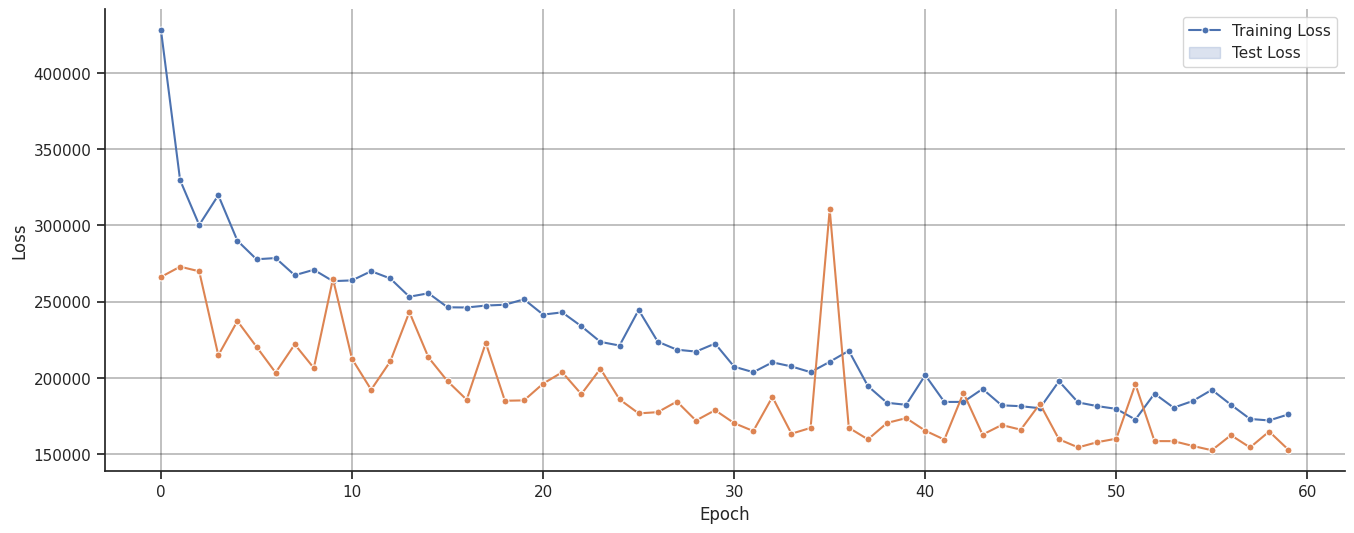

In [176]:
fig, ax = plt.subplots(figsize=(16, 6))
# Get training and test loss histories
loss = pd.DataFrame({
    'training_loss': history.history["loss"], 
    'test_loss': history.history["val_loss"]
    })
# Create count of the number of epochs
epoch_count = np.arange(loss.training_loss.shape[0])
# Visualize loss history
sns.lineplot(data=loss, x=epoch_count, y='training_loss', marker= '.', markersize=10, ax=ax)
sns.lineplot(data=loss, x=epoch_count, y='test_loss', marker= '.', markersize=10, ax=ax)
ax.legend(["Training Loss", "Test Loss"])
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.grid(visible=True, color='black', linewidth=.35)
plt.show()